In [1]:
# spark must be first found using findspark package
import findspark
findspark.init()

In [2]:
# establish a spark session with 50 executors
from pyspark.sql import SparkSession
spark = SparkSession \
        .builder \
        .master("yarn") \
        .appName("testing") \
        .config("spark.executor.instances", "50") \
        .config("spark.executor.memory","5g") \
        .config("spark.driver.memory","30g") \
        .config("spark.executor.cores",'1') \
        .config("spark.scheduler.mode","FIFO") \
        .config("spark.driver.maxResultSize", '4g') \
        .getOrCreate()

In [93]:
# when wanting to stop the spark session
spark.stop()

In [3]:
# import the review dataset
review = spark.read.parquet('/yelp/review.parquet').repartition(300).cache()
business = spark.read.parquet('/yelp/business.parquet').repartition(100).cache()
users = spark.read.parquet('/yelp/users.parquet').repartition(200).cache()

In [4]:
from pyspark.sql.functions import greatest
# generate column for total aggregated count of votes
review = review.withColumn('totalvotes', review.cool+review.funny+review.useful)

# select only the reviews where one has at least 50 %
review = review.withColumn('max_vote', greatest(review.cool,review.funny, review.useful))
review = review.withColumn('max_ratio', review.max_vote/review.totalvotes)
review = review.where( (review.max_vote / review.totalvotes) >=0.5)

# filter out reviews with less than 10 reviews
review = review.where(review.totalvotes > 10)
review.count()

45361

In [37]:
# WORD2VEC fitting
import time
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec
start = time.time()

# tokenize
tokenizer = Tokenizer(inputCol="text", outputCol="words")
dataset = tokenizer.transform(review)

# drop original text column
dataset = dataset.drop("text")

# Stop word removal
stopremove = StopWordsRemover(inputCol='words',outputCol='cleaned')
dataset = stopremove.transform(dataset)

dataset = dataset.drop('words').repartition(300).cache()

#fit a word2vec model 
word2Vec = Word2Vec(vectorSize=500, minCount=0, numPartitions=300, inputCol="cleaned", outputCol="word2vec")
model = word2Vec.fit(dataset)
dataset = model.transform(dataset).drop('cleaned')

end = time.time()

In [18]:
# Using PCA on the new data to understand variance
from pyspark.ml.feature import PCA

pca = PCA(k=10, inputCol= "word2vec",outputCol="pca_text")
pca_model = pca.fit(dataset)
pca_result = pca_model.transform(dataset)

In [12]:
pca_model.explainedVariance.values

array([  6.38483002e-01,   3.33531543e-01,   1.31776342e-02,
         6.05417036e-03,   1.40412141e-03,   9.50853810e-04,
         4.10313876e-04,   3.40604943e-04,   3.17370084e-04,
         2.19015785e-04])

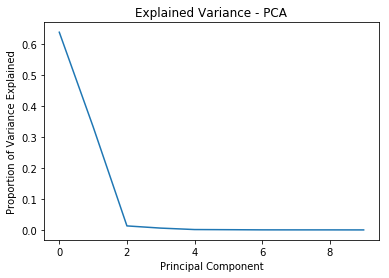

In [13]:
import numpy as np
import matplotlib.pyplot as plt
#np.arange(len(result.columns))
#result.columns
plt.plot(np.arange(10), np.array(pca_model.explainedVariance.values))
plt.title('Explained Variance - PCA')
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.show()

In [19]:
pca_result.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- totalvotes: long (nullable = true)
 |-- max_vote: long (nullable = true)
 |-- max_ratio: double (nullable = true)
 |-- word2vec: vector (nullable = true)
 |-- pca_text: vector (nullable = true)



In [20]:
pca_result_pd = pca_result.toPandas()
pca_result_pd['maxcat'] = pca_result_pd[['cool','useful','funny']].idxmax(axis = 1 )
pca_result_pd['maxcat'] = pca_result_pd['maxcat'].astype('category')
pca_result_pd['maxcat_code'] = pca_result_pd['maxcat'].cat.codes

In [29]:
np.array(pca_result.pca_text)

()

In [34]:
def extract_pca(row):
    return tuple(row.pca_text.toArray().tolist())
pca_result = pca_result.rdd.map(extract_pca).toDF()

In [35]:
pca_result_pd = pca_result.toPandas()

In [36]:
pca_result_pd

,_1,_2,_3,_4,_5,_6,_7,_8,_9,_10
0,-30.789240,-10.892491,-0.990623,-1.447281,0.579560,-0.440696,0.459479,-0.065809,-0.170060,-0.278636
1,-38.877122,-15.771117,-1.384870,-2.764518,0.138499,0.000686,-0.090123,-0.019927,0.192740,-0.132707
2,-44.012848,-1.516899,0.081406,-1.741127,0.357383,-0.185108,0.408793,-0.038201,0.264831,-0.146519
3,-31.047350,-7.607187,-1.891952,-1.798512,0.595744,-0.078243,-0.140829,-0.177431,-0.053422,-0.177464
4,-26.156230,-4.694557,-0.746292,-1.594695,0.277798,0.408737,0.119333,-0.150112,-0.107074,-0.002616
5,-36.170030,-10.028445,-1.770386,-2.261118,0.304418,0.383768,0.081994,-0.275085,0.122050,-0.126143
6,-42.863779,-11.326796,-1.690352,-2.392487,0.204274,-0.268977,-0.186833,0.066008,-0.007504,-0.246483
7,-42.240175,-5.582063,-1.281227,-2.378863,0.066819,0.563786,0.173515,-0.067769,0.169232,-0.130938
8,-33.801608,-9.693103,-2.151167,-2.684766,0.005980,0.188977,-0.064514,-0.023763,-0.015437,0.002172
9,-42.894813,-1.495412,-0.243278,-2.503510,0.206453,0.082621,0.097538,-0.094296,0.079588,-0.240494


In [33]:
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne= TSNE(early_exaggeration=10,n_jobs=20)
tsne_output = tsne.fit_transform(np.array(pca_result_pd.pca_text))

AssertionError: X should be 2D array.

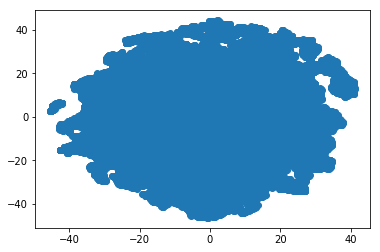

In [102]:
plt.scatter(tsne_output[:,0],tsne_output[:,1],, c)
plt.show()

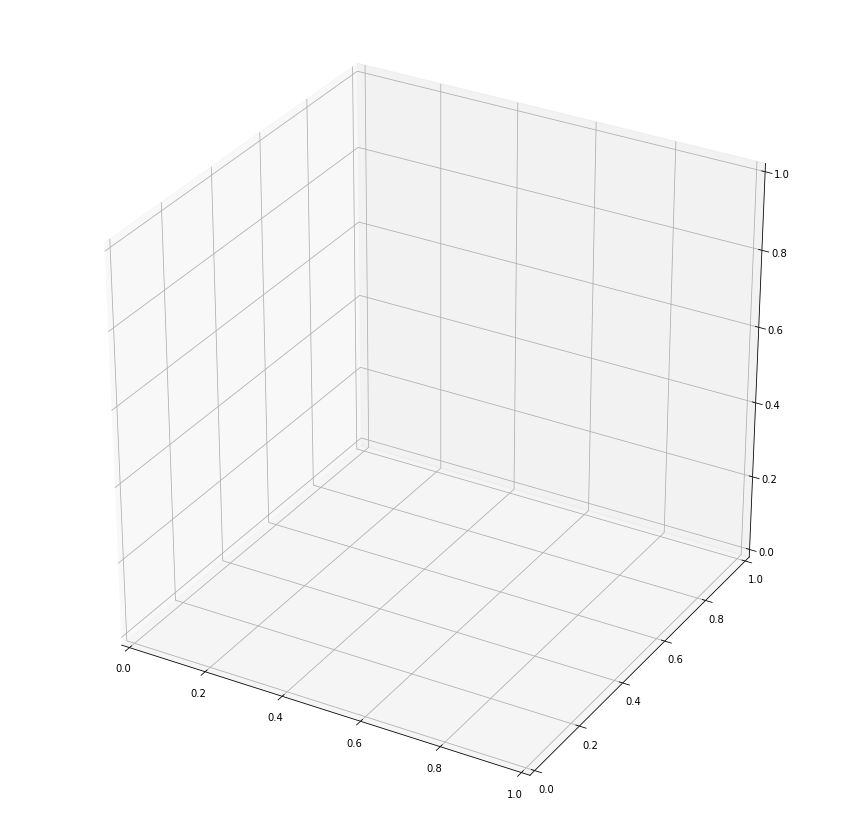

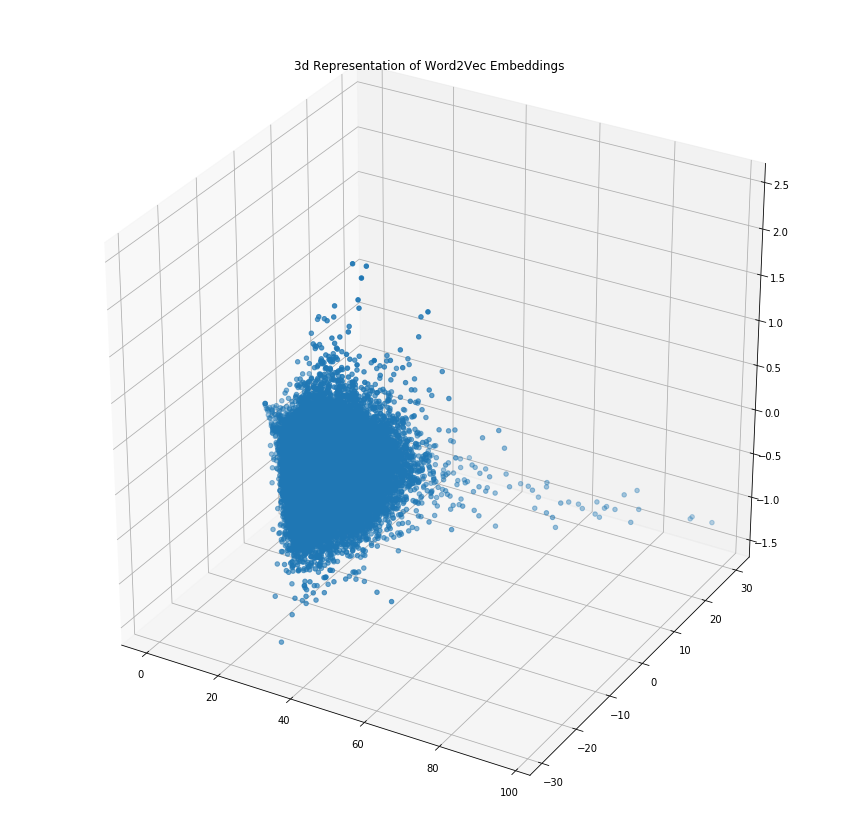

In [62]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111,projection='3d')

ax.scatter(xs=result_pd._1, ys=result_pd._2, zs = result_pd._3)
plt.title('3d Representation of Word2Vec Embeddings')
plt.show()

In [90]:
result_pd['maxcat'] = data[['cool','useful','funny']].idxmax(axis = 1 )
result_pd['maxcat'] = result_pd['maxcat'].astype('category')
result_pd['maxcat_code'] = result_pd['maxcat'].cat.codes

In [91]:
result_pd

,_1,_2,_3,maxcat,maxcat_code
0,-30.418854,-11.655408,-0.356006,useful,2
1,-34.750533,-14.658859,-0.811544,useful,2
2,-33.083126,-14.281905,-0.562658,cool,0
3,-27.944723,-11.717186,-0.696101,cool,0
4,-29.584474,-19.131403,-0.691758,useful,2
5,-17.765374,-12.267815,-0.278009,useful,2
6,-33.973325,-19.866324,-0.122932,useful,2
7,-26.687584,-22.260342,-0.215497,useful,2
8,-34.451625,-12.422050,-0.731364,useful,2
9,-27.112611,-20.167832,0.285636,useful,2
